# Flowers Classification
## 개요
- tensorflow_datasets에 포함된 tf_flowers 데이터를 활용하여 Image Classification Task를 진행합니다.
- 모델 성능을 고도화하기 위해 Pre-trained Model을 활용합니다.

## 목차
1. 데이터셋 내려받기
2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
3. 모델 설계하기
4. 모델 학습시키기
5. 모델 성능 평가하기
6. 모델 Save
7. 모델 활용하기
8. 결론

## 회고
- 어렵거나 몰랐던 개념 공부하기
- KEEP
- PROBLEM
- TRY

## Reference
---

## 1. 데이터셋 내려받기

In [1]:
# 텐서 플로우 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


### tf.flowers datasets 살펴보기
- [tf.flowers 공식문서](https://www.tensorflow.org/datasets/catalog/tf_flowers) 에서 데이터를 살펴봅니다.
- 데이터의 용량 : 218.21 MiB
- 이미지 데이터의 개수 : train data 3,670개
- label의 class 개수(꽃의 종류) : num_classes=5 (총 5종류의 꽃이 있는 데이터셋 입니다.)

In [2]:
# 텐서플로우에서 제공하는 데이터셋 사용

import tensorflow_datasets as tfds

tfds.__version__

'4.4.0'

In [6]:
!mkdir -p ~/aiffel/flowers/FlowersImages   # ~/aiffel/flowers/FlowersImages 경로에 디렉토리를 생성
!ln -s ~/tensorflow_datasets/* ~/aiffel/flowers/

# ln은 링크를 생성하는 명령어입니다.
# -s 옵션은 심볼릭 링크를 생성하는 옵션입니다.
# ~/data/*는 ~/data/ 디렉토리 안의 모든 파일에 대한 패턴입니다.
# 이를 ~/aiffel/cats_vs_dogs/ 디렉토리에 심볼릭 링크로 연결합니다.

ln: failed to create symbolic link '/aiffel/aiffel/flowers/downloads': File exists
ln: failed to create symbolic link '/aiffel/aiffel/flowers/tf_flowers': File exists


In [7]:
# 데이터셋 다운로드 & 압축 해제
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='tf_flowers',
                                   untar=True)

# untar=True: 압축 파일을 해제할 것인지를 결정하는 매개변수입니다. untar=True로 설정하면 tar 형식의 압축 파일을 자동으로 해제합니다.

228827136/228813984 [==============================] - 1s 0us/step


In [8]:
# train, valid, test 데이터 나누기

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/flowers/',   # data_dir='~/aiffel/flowers/': 데이터셋이 저장될 디렉토리를 지정
    download=False,   # 데이터셋을 인터넷에서 다운로드 할지? 로컬에 다운로드된 데이터셋 사용하므로 False로 설정
    with_info=True,   # 데이터셋의 메타데이터도 함께 로드할지 여부를 결정
    as_supervised=True,
)

In [9]:
# 각각의 데이터셋 확인하기
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [10]:
# 파일이 저장된 경로 확인
print(data_dir)

/aiffel/.keras/datasets/tf_flowers


## 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
datasets을 모델에 활용할 수 있도록 전처리합니다.

In [11]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import warnings
warnings.filterwarnings(action='ignore')

In [12]:
# 데이터 시각화를 위해 matplotlib 가져오기

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("슝~")

# %matplotlib inline: Jupyter Notebook 환경에서 플롯을 노트북 셀 안에 즉시 표시하도록 하는 명령어
# %matplotlib inline을 사용하면 그래프를 생성한 셀 바로 아래에 표시됩니다.
# %config InlineBackend.figure_format = 'retina': 고해상도의 그림을 생성하도록 하는 명령어입니다. 
# 특히, 'retina'는 레티나 디스플레이에서 더 높은 해상도를 지원합니다.
# 구성(config)는 다양한 기능과 설정을 선택할 수 있는 컴퓨터의 코드

슝~


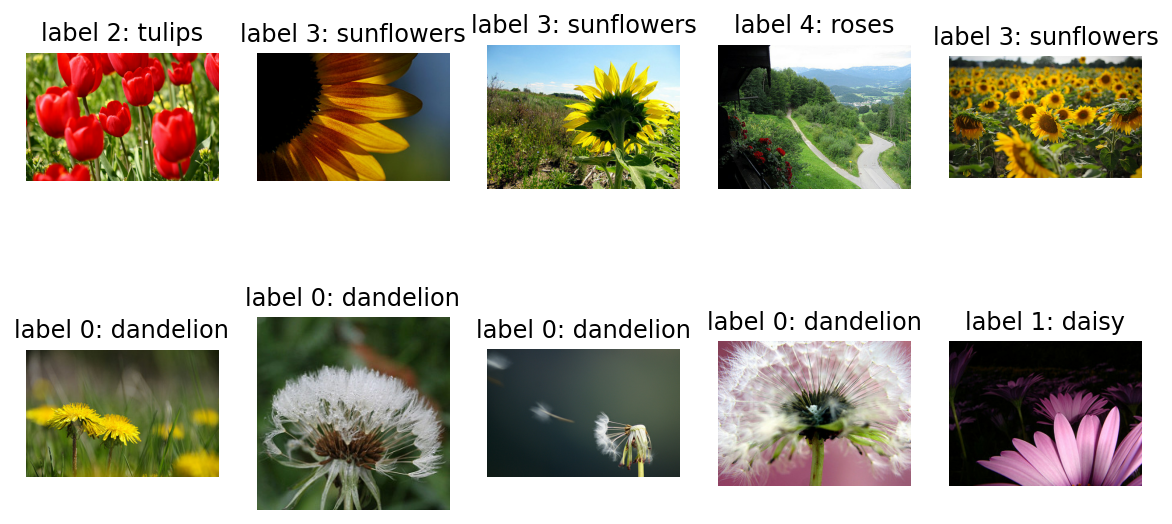

In [13]:
# raw_train 안의 데이터 확인하기
# tf.data.Dataset에서 제공하는 take라는 함수를 사용하여
# take()는 인수로 받은 만큼의 개수만큼의 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수

plt.figure(figsize=(10, 5))

# label' 특성에 대한 int2str 메서드를 사용하여 정수 형식의 레이블을 문자열로 변환하는 함수를 정의
get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)   #  2행 5열의 서브플롯 중에 현재 인덱스에 해당하는 위치에 서브플롯을 생성
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

label 확인하기    
- label 0 : dandelion
- label 1 : daisy
- label 2 : tulips
- label 3 : sunflowers
- label 4 : roses
    
### 이미지를 모두 같은 크기로 formatting
모델 학습을 위해 이미지 사이즈를 통일시켜줍니다.

In [14]:
# 이미지를 같은 포멧으로 통일 : format_example() 함수를 활용하여

IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("슝~")


# tf.cast(image, tf.float32): 이미지를 tf.float32 타입으로 변환합니다. 
# TensorFlow에서는 데이터 타입이 일치해야 효율적인 계산이 가능하므로, 
# 주로 신경망 모델에 입력으로 주입하기 전에 데이터 타입을 맞추는 작업이 필요합니다.

# (image/127.5) - 1: 픽셀 값을 정규화합니다. 
# 이미지의 픽셀 값은 일반적으로 0에서 255 사이의 값을 가지므로, 이를 -1에서 1 사이의 값으로 정규화합니다. 
# 이는 일반적으로 이미지 데이터를 모델에 입력하기 전에 수행되는 표준적인 전처리 방법 중 하나입니다.

# tf.image.resize(image, (IMG_SIZE, IMG_SIZE)): 이미지의 크기를 IMG_SIZE로 조정합니다. 

슝~


In [15]:
# format_example()을 사용하여 IMG_SIZE를 160으로 지정 -> 모든 이미지의 크기를 (160, 160, 3)으로 통일시키기
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


데이터 사이즈가 (160, 160, 3)으로, 데이터 타입이 (tf.float32, tf.int64)으로 통일되었습니다.

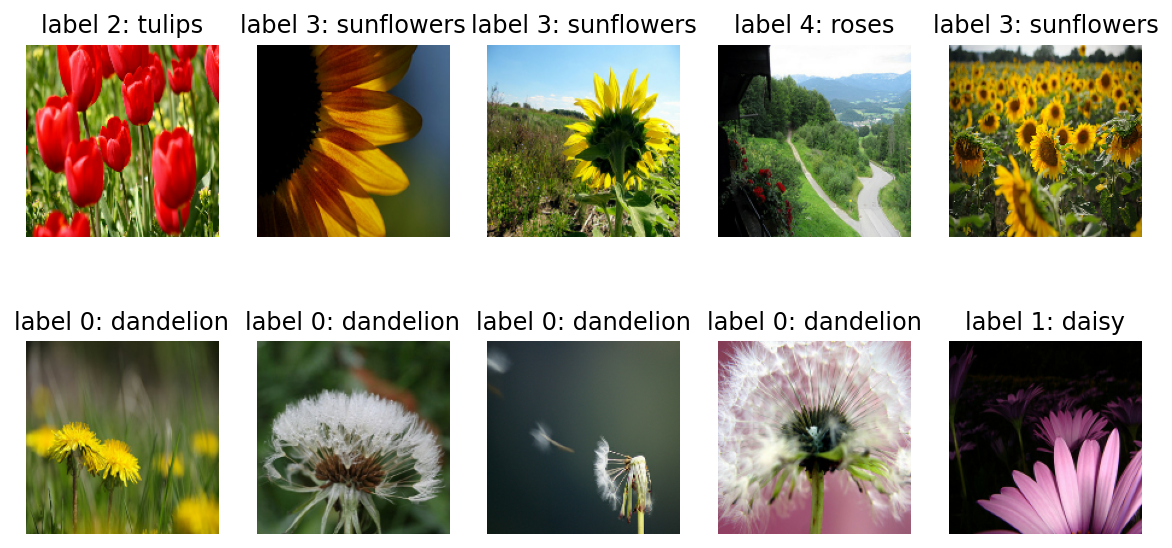

In [16]:
# 데이터의 사이즈가 잘 통일되었는지 이미지를 출력하여 확인하기
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### train_batches, validation_batches, test_batches를 준비

In [20]:
# 모델을 학습시킬 데이터를 준비
# 한 스텝에 학습시킬 데이터의 개수인 BATCH_SIZE와 학습 데이터를 적절히 섞어줄 SHUFFLE_BUFFER_SIZE를 설정

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("슝~")

슝~


In [21]:
# train, valid, test datasets 각각에 배치 사이즈를 적용
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("슝~")

슝~


In [22]:
# train_batches에서 하나의 batch만 꺼내 데이터 확인해보기

for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

## 3. 모델 설계하기
- VGG16 Model 활용 : 모델 성능을 고도화하기 위해 base model로 활용합니다.
- 데이터셋이 3,670개로 매우 적으므로 Fully connected layers에서만 모델을 학습시키는 Classifier를 만들어줍니다.

### VGG16 Model 불러오기

In [28]:
# 모델 생성에 필요한 함수 가져오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

print("슝~")

슝~


In [23]:
# VGG 모델을 base_model의 변수로 불러오기
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

# include_top=False :  
# 모델의 최상위 레이어(완전 연결 레이어)를 포함할지 여부를 결정하는 매개변수로, False로 설정하면 최상위 레이어를 포함하지 않습니다.
# weights='imagenet' : 이미지넷으로 트레이닝 된 모델을 불러오기

58900480/58889256 [==============================] - 0s 0us/step


In [24]:
# 넣기 전에 image_batch의 원래 사이즈를 다시 확인해보기

image_batch.shape

TensorShape([32, 160, 160, 3])

In [25]:
# 모델에 이 배치를 넣으면 shape가 어떻게 바뀔지 확인

feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

- 이미지의 개수는 32장으로 여전히 같은데, 이미지의 사이즈가 많이 달라졌습니다.
- height와 width는 각각 5로 매우 작아졌고, 512로 channel이 늘어났습니다.
- 이 벡터는 이미지에서 특징을 추출해 낸 "특징 벡터"라고 부르기도 합니다.

In [26]:
# 모델의 구조 살펴보기
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

모델 구성  
- 첫 번째 블록 : 2개의 Conv 레이어와 1개의 Pooling 레이어
- 두 번째 블록 : 2개의 Conv 레이어와 1개의 Pooling 레이어
- 세 번째 블록 : 3개의 Conv 레이어와 1개의 Pooling 레이어
- 네 번째 블록 : 3개의 Conv 레이어와 1개의 Pooling 레이어
- 다섯 번째 블록 : 3개의 Conv 레이어와 1개의 Pooling 레이어
- 여섯 번째 블록 : 3개의 Dense 레이어는 Transfer Learning을 수행하며 새로 학습시킬 예정입니다.
    
### Fully Connected layer 만들기
Fully connected layer에는 1차원 벡터 배열만 입력이 가능하므로,   
Global Average Pooling 계층을 만들어 3차원 배열을 1차원 배열로 바꿔줍니다.

In [29]:
# Global Average Pooling 계층을 만들기 (3차원 배열을 1차원 배열로 바꾸기)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
print("슝~")

슝~


In [30]:
# global_average_layer(1차원 배열=벡터)에 위에서 VGG16이 출력했던 feature_batch를 입력해보기
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


벡터의 shape이 [32, 1, 1, 512] 즉 [32, 512] 로, 다시 말하면 1차원 배열로 잘 변환되었습니다.

### Dense layers 붙여주기
위에서 만든 Fully Connected layer에 Dense layers를 붙여주면 Classifier가 완성됩니다.

In [32]:
# Dense layers 만들기
dense_layer = tf.keras.layers.Dense(32, activation='relu')

# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')  # 최종적으로 분류하는 class가 5개이므로 유닛수는 5

# feature_batch_average가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 5)


#### Freeze
VGG16에 해당하는 base_model은 학습을 시키지 않을 예정이니 학습 여부를 결정하는 trainable 변수를 False로 지정해 "꺼주겠"습니다.

In [33]:
# base_model(=VGG16)은 학습을 시키지 않도록 설정
base_model.trainable = False
print("슝~")

슝~


In [34]:
# 최종 모델
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
print("슝~")

슝~


In [35]:
# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 14,731,269
Trainable params: 16,581
Non-trainable params: 14,714,688
_________________________________________________________________


## 4. 모델 학습시키기

In [36]:
# model compile

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [37]:
# 초기 손실과 정확도 값을 확인(예상)
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 1s - loss: 1.5607 - accuracy: 0.2970WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 8s 168ms/step - loss: 1.5607 - accuracy: 0.2970
initial loss: 1.56
initial accuracy: 0.30


accuracy가 30% 정도로 매우 저조합니다.  
좋은 모델이지만 evaluate 결과가 저조하므로 많은 epochs로 학습시키되, 적절히 학습되면 early stopping을 활용하여 학습을 종료하겠습니다.
이제 최종 성능을 확인할 모델을 학습시켜보겠습니다.

In [38]:
# Early stoppin & Callbacks 설정
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 3,
    verbose=1,
    mode = 'auto'
)

In [39]:
# 모델 학습 - model fit (EPOCHS=5)
EPOCHS = 20

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    callbacks=[early_stopping]
)

Epoch 1/20
92/92 [==============================] - 13s 117ms/step - loss: 1.4991 - accuracy: 0.3709 - val_loss: 1.3975 - val_accuracy: 0.4932
Epoch 2/20
92/92 [==============================] - 8s 78ms/step - loss: 1.3747 - accuracy: 0.4973 - val_loss: 1.2912 - val_accuracy: 0.5804
Epoch 3/20
92/92 [==============================] - 8s 78ms/step - loss: 1.2740 - accuracy: 0.5811 - val_loss: 1.1944 - val_accuracy: 0.6431
Epoch 4/20
92/92 [==============================] - 8s 79ms/step - loss: 1.1867 - accuracy: 0.6216 - val_loss: 1.1173 - val_accuracy: 0.6703
Epoch 5/20
92/92 [==============================] - 8s 79ms/step - loss: 1.1115 - accuracy: 0.6567 - val_loss: 1.0445 - val_accuracy: 0.6921
Epoch 6/20
92/92 [==============================] - 8s 80ms/step - loss: 1.0460 - accuracy: 0.6805 - val_loss: 0.9860 - val_accuracy: 0.7193
Epoch 7/20
92/92 [==============================] - 8s 80ms/step - loss: 0.9894 - accuracy: 0.6979 - val_loss: 0.9320 - val_accuracy: 0.7030
Epoch 8/20


최종 정확도가 약 75% 정도입니다.  

## 5. 모델 성능 평가하기
그래프로 학습 과정을 살펴봅니다.

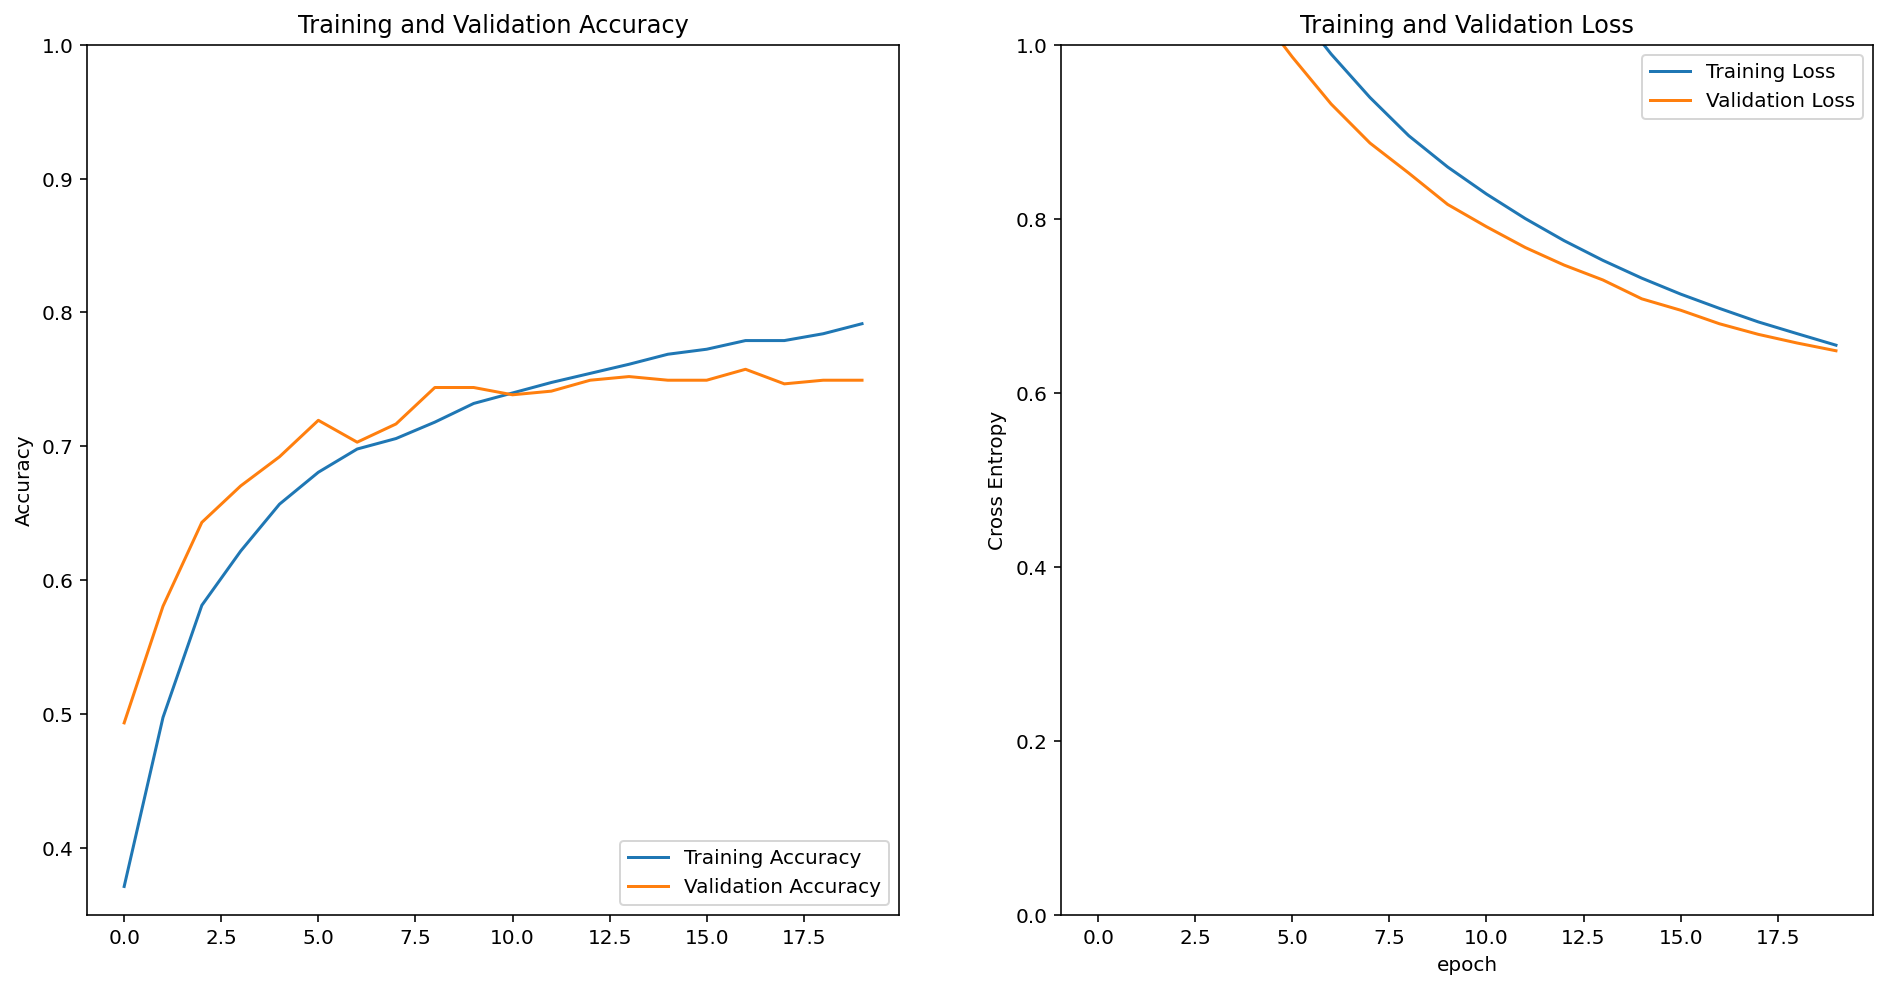

In [40]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')   # 범례를 그림에 추가하고 위치를 우하단으로 지정
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])   # y축의 범위를 설정 : 현재 y축 범위 중에서 가장 작은 값(최소값) ~ 1 로 설정
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

32개의 test sample에 대한 예측 결과를 눈으로 확인해보겠습니다.  
샘플을 test_batches에서 가져와서 예측 결과를 만들어보겠습니다.

In [42]:
# test data sample prediction
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[6.64011985e-02, 8.35773423e-02, 4.85291541e-01, 2.04859436e-01,
        1.59870490e-01],
       [9.91086423e-01, 4.39509936e-03, 3.26426729e-04, 2.66785687e-03,
        1.52419345e-03],
       [7.05363095e-01, 1.29298270e-01, 3.43073495e-02, 1.04637027e-01,
        2.63942797e-02],
       [1.08546354e-02, 1.88042559e-02, 5.25778711e-01, 3.26315537e-02,
        4.11930829e-01],
       [6.83635771e-01, 2.36585826e-01, 2.66133714e-02, 2.80155540e-02,
        2.51493976e-02],
       [8.26884031e-01, 8.29525515e-02, 2.24154890e-02, 5.30079231e-02,
        1.47399716e-02],
       [4.03563976e-02, 3.19123827e-02, 4.28790480e-01, 3.29195380e-01,
        1.69745401e-01],
       [3.54031712e-01, 3.95907879e-01, 8.30257125e-03, 2.18598440e-01,
        2.31594201e-02],
       [5.46820946e-02, 1.16386320e-02, 5.72108701e-02, 6.81080282e-01,
        1.95388064e-01],
       [9.95681763e-01, 2.08399235e-03, 5.39713292e-05, 1.94523903e-03,
        2.35023675e-04],
       [9.48993385e-01, 3.2108

0과 1 사이의 값으로 확률값이 출력되었습니다.  
Prediction 값들을 실제 추론한 라벨로 변환해보겠습니다.

In [43]:
# prediction값들을 실제 라벨(정답)로 변환하기
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 1, 3, 4, 0, 3, 2, 0, 2, 2, 2, 0,
       1, 0, 1, 3, 2, 4, 2, 3, 0, 4])

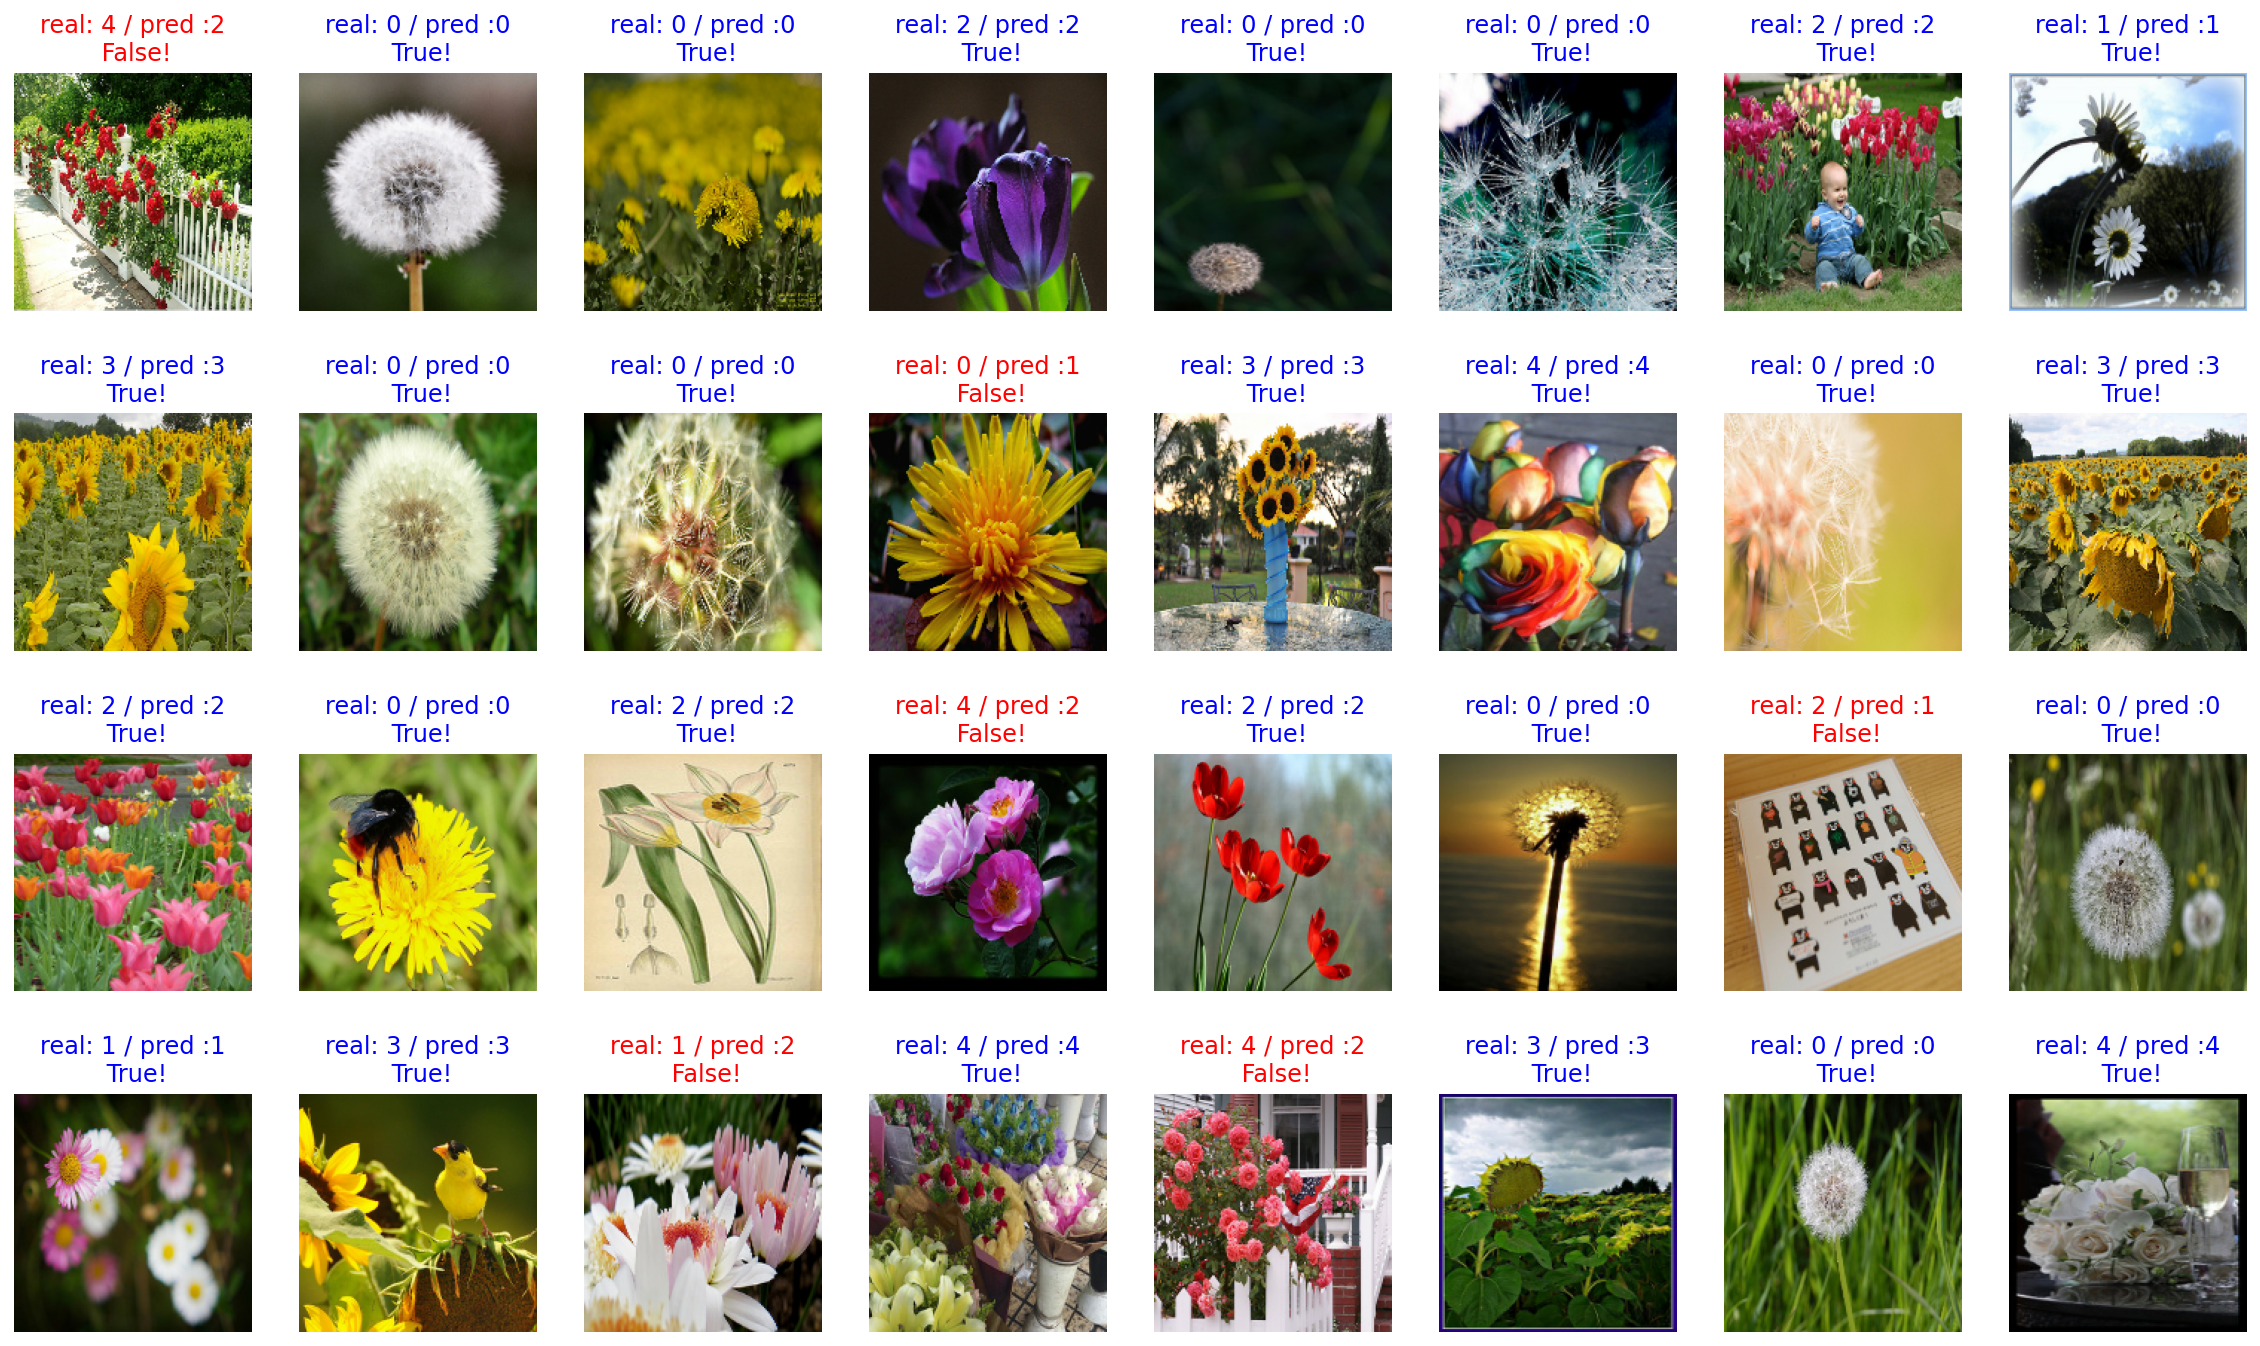

In [44]:
# test sample prediction - 이미지와 함께 시각화

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

32개에 대한 정확도도 확인해보겠습니다.

In [45]:
# prediction 값의 정확도(accuracy) 구하기

count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) 

81.25


약 81% 내외의 정확도를 갖습니다.

## 6. 모델 Save
모델을 Save하여 다시 Load 해와서 활용할 수 있도록 작업합니다.

In [46]:
# 모델을 저장할 폴더 만들기
!mkdir -p ~/aiffel/flowers_model_save/checkpoint
!mkdir -p ~/aiffel/flowers_model_save/images

In [47]:
# checkpoint(model weight)을 저장할 경로 지정 및 checkpoint 파일 생성

import os

# 모델을 저장할 디렉토리와 파일 경로를 지정하고, 변수 생성
checkpoint_dir = os.getenv("HOME") + "/aiffel/flowers_model_save/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

# checkpoint_dir가 없으면 해당 디렉토리 생성하고 checkpoint 파일 생성
if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

# checkpoint 파일이 있으면 checkpoint 파일 생성
if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


## 7. 모델 활용하기
학습된 모델에 원하는 이미지를 입력하여 예측 결과를 확인해봅니다.

In [48]:
# 준비된 이미지 연결하기
!ln -s ~/tensorflow_datasets/* ~/aiffel/flowers_model_save/images/

In [49]:
# 이미지 파일이 준비된 후 , tensorflow 모델에 입력해주기 위해 load_img, img_to_array 함수를 가져오기
from tensorflow.keras.preprocessing.image import load_img, img_to_array

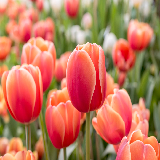

In [50]:
# 이미지 사이즈 설정
IMG_SIZE = 160

# 모델을 저장할 디렉토리와 파일 경로를 지정하고, 변수 생성
img_dir_path = os.getenv("HOME") + "/aiffel/flowers_model_save/images"
tulips_image_path = os.path.join(img_dir_path, 'tulips.jpg')

# 튤립 이미지 로드해보기
tulips_image = load_img(tulips_image_path, target_size=(IMG_SIZE, IMG_SIZE))
tulips_image

In [51]:
# 모델에 넣을 수 있도록 이미지를 array, 즉 배열 자료형으로 변환하기
tulips_image = img_to_array(tulips_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
tulips_image.shape

(1, 160, 160, 3)

### 이미지를 모델에 넣어 예측하기
튤립의 label은 2이므로, [0.0, 0.0, 1.0, 0.0, 0.0]에 가까운 확률 분포가 예측될 것입니다.  
라벨 확인하기  
- label 0 : dandelion
- label 1 : daisy
- label 2 : tulips
- label 3 : sunflowers
- label 4 : roses

In [52]:
prediction = model.predict(tulips_image)
prediction

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        1.3315033e-37]], dtype=float32)

In [54]:
# 이미지를 예측하는 함수 만들기 (위의 과정을 함수로)

def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]          # 결과에서 첫번째(인덱스0) 예측 결과를 가져오기
    dandelion_percentage = round(prediction[0] * 100)   # 예측 결과에서 dandelion 클래스에 해당하는 확률을 백분율로 계산
    daisy_percentage = round(prediction[1] * 100)   # 예측 결과에서 daisy 클래스에 해당하는 확률을 백분율로 계산
    tulips_percentage = round(prediction[2] * 100)   # 예측 결과에서 tulips 클래스에 해당하는 확률을 백분율로 계산
    sunflowers_percentage = round(prediction[3] * 100)   # 예측 결과에서 sunflowers 클래스에 해당하는 확률을 백분율로 계산
    roses_percentage = round(prediction[4] * 100)   # 예측 결과에서 roses 클래스에 해당하는 확률을 백분율로 계산
    print(f"This image seems {dandelion_percentage}% dandelion, {daisy_percentage}% daisy, {tulips_percentage}% tulips, {sunflowers_percentage}% sunflowers, and {roses_percentage}% roses.")

In [57]:
prediction

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        1.3315033e-37]], dtype=float32)

This image seems 0% dandelion, 0% daisy, 100% tulips, 0% sunflowers, and 0% roses.


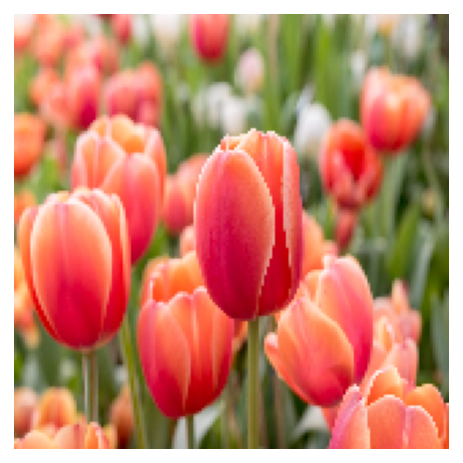

In [58]:
# 튤립 이미지를 함수에 넣어보기
filename = 'tulips.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% dandelion, 0% daisy, 100% tulips, 0% sunflowers, and 0% roses.


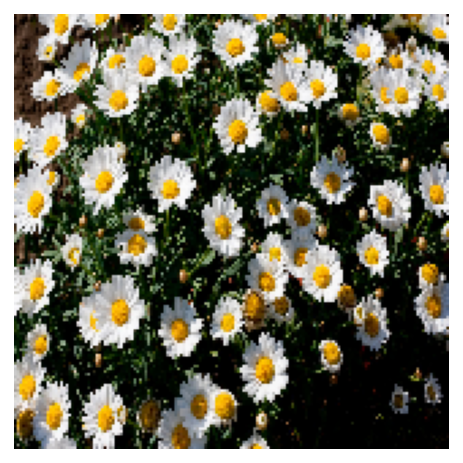

In [59]:
# 데이지 이미지를 함수에 넣어보기
filename = 'daisy.jpg'

show_and_predict_image(img_dir_path, filename)

## 8. 결론
### 정확도 (모델 성능)
- 모델 학습 결과 최종 정확도 약 75%
- test sample data의 정확도 약 81%

### 원하는 이미지 분류 결과 (모델 활용) 
2개 이미지 모두 100%의 확률로 정답을 맞춤.

---
## 회고


### 어렵거나 몰랐던 개념 공부하기

1. symbolic link
- 심볼릭 링크는 절대 경로 또는 상대 경로의 형태로 된 다른 파일이나 디렉터리에 대한 참조를 포함하고 있는 특별한 종류의 파일이다. 
- 쉽게 말해 윈도우의 '바로가기'와 비슷한 역할이며, 특정 파일 혹은 디렉토리를 가리키는 링크라고 보면 된다.
- 심볼릭 링크는 원본 파일을 가리키는 포인터와 같은 존재로, 심볼릭 링크로 파일을 수정해도 원본 파일이 수정된다.
- 코드 보기  
ln -s [원본 경로] [링크 경로]

2. tensorflow datasets을 다운로드 및 압축 해제 하는 방법
- tensorflow datasets을 공식문서 페이지 내의 url로 다운로드 및 압축 해제가 가능하다.
- url은 페이지 내 최하단에 있다!  
- [tf_flowers 페이지](https://www.tensorflow.org/datasets/catalog/tf_flowers)

3. early_stopping 적용
- 개념은 배웠으나 어떤 단계에서 어떻게 적용하는지는 확실히 알지 못했었다.
- 적용 단계 : model compile 후 model fit 전에 적용한다.
- 활용하는 인자는 아래 코드에서 확인하기.
- 코드 보기

In [64]:
# early_stopping = EarlyStopping(
#     monitor = 'val_loss',
#     min_delta = 0.001,
#     patience = 3,
#     verbose=1,
#     mode = 'auto'
# )

### KEEP
- tensorflow datasets을 다운로드하여 사용하는 과정에서 여러 시행착오를 겪었지만 (flowers_classification.ipynb) 성공적으로 다운로드 하였다.
- 심볼릭 링크의 의미와 활용을 공부하였다.
- early stopping을 시도해보았다.
- 전반적인 단계(과정)을 대략적으로 이해하며 진행하였다.

### PROBLEM
- 파일 저장 경로 설정하는 방법이 아직 낯설다.
- 저장한 파일의 경로 확인하는 방법을 코드로 확인하는 방법을 모른다.
- 데이터셋을 다운받은 후 이미지를 확인해보는 것과 class(label) 확인하는 방법이 낯설다.

### TRY
- 파일 저장 경로 설정, 경로 확인 방법, tfds 활용 방법 한 번 더 익히고 적용해보기
- 다운받은 데이터셋 내의 이미지 확인 방법, class 확인 방법 찾아보고 적용해보기

---
## Reference

- [tensorflow datasets 확인](https://www.tensorflow.org/datasets/catalog/tf_flowers)
- [tensorflow datasets 다운로드](https://www.tensorflow.org/tutorials/load_data/images)
- [early stopping](https://sevillabk.github.io/1-early-stopping/)
- [datasets 규모](http://taewan.kim/tutorial_manual/ml_yearning/020.setup_dev_test_set/7/)
- [freepik - image download](https://www.freepik.com/)